In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv')
train.head()

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747
1,19,2012-03-17 03:48:44,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,2,588a679f-23d2-11e8-a6a3-ec086b02610b,115,Justin Brown,6f12067d-5567-11e8-b3c0-dca9047ef277,3,1024,747
2,0,2014-05-11 11:56:46,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,1,59279ce3-23d2-11e8-a6a3-ec086b02610b,96,Erin Boydston,6faa92d1-5567-11e8-b1ae-dca9047ef277,1,1024,747
3,0,2013-10-06 02:00:00,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,1,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,57,Erin Boydston,6f7d4702-5567-11e8-9e03-dca9047ef277,1,1024,747
4,0,2011-07-12 13:11:16,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg,3,599fbd89-23d2-11e8-a6a3-ec086b02610b,46,Justin Brown,6f1728a1-5567-11e8-9be7-dca9047ef277,3,1024,747


In [3]:
train_clean = train[train['height']==747]

In [4]:
train['category_id'].value_counts()

0     131457
19     14106
13      8623
11      7209
8       6938
1       6102
16      5975
17      4759
3       3398
18      3035
4       2210
14      1361
10      1093
22        33
Name: category_id, dtype: int64

In [5]:
im = plt.imread('train/59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg')

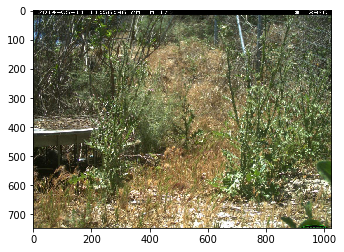

In [6]:
plt.imshow(im)
plt.show()

In [7]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189960 entries, 0 to 196298
Data columns (total 11 columns):
category_id       189960 non-null int64
date_captured     189960 non-null object
file_name         189960 non-null object
frame_num         189960 non-null int64
id                189960 non-null object
location          189960 non-null int64
rights_holder     189960 non-null object
seq_id            189960 non-null object
seq_num_frames    189960 non-null int64
width             189960 non-null int64
height            189960 non-null int64
dtypes: int64(6), object(5)
memory usage: 17.4+ MB


In [8]:
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, Flatten, MaxPooling2D, Dropout

Using TensorFlow backend.


In [9]:
shape = plt.imread(f'train/{train_clean["file_name"][0]}').shape

category_to_idx = {c:i for i,c in enumerate(train['category_id'].unique())}
idx_to_category = {i:c for i,c in enumerate(train['category_id'].unique())}

n_output = len(category_to_idx)

In [10]:
input_layer = Input(shape=shape)
x = Convolution2D(16, kernel_size=3,activation='relu')(input_layer)
x = MaxPooling2D()(x)
x = Convolution2D(32, kernel_size=3,activation='relu')(x)
x = MaxPooling2D()(x)
x = Convolution2D(64, kernel_size=3,activation='relu')(x)
x = MaxPooling2D()(x)
x = Convolution2D(128, kernel_size=3,activation='relu')(x)
x = MaxPooling2D()(x)
x = Convolution2D(256, kernel_size=3,activation='relu')(x)
x = MaxPooling2D()(x)
x = Convolution2D(512, kernel_size=3,activation='relu')(x)
x = MaxPooling2D()(x)
x = Dense(512,activation='relu')(Flatten()(x))
x = Dropout(rate=0.5)(x)
output = Dense(n_output, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 747, 1024, 3)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 745, 1022, 16)     448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 372, 511, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 370, 509, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 185, 254, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 183, 252, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 91, 126, 64)       0         
__________

In [11]:
def generator(batch_size,iterations=10):
    for i in range(iterations):
        files = train_clean['file_name'][i*batch_size:(i+1)*batch_size].values
        catergories = train_clean['category_id'][i*batch_size:(i+1)*batch_size].values
        X = np.zeros(shape=(batch_size,*shape))
        y = np.zeros(shape=(batch_size,n_output))
        for f in range(len(files)):
            X[f] = plt.imread(f'train/{files[f]}')/255
            c = catergories[f]
            y[f,category_to_idx[c]] = 1 
        yield X,y

In [14]:
len(train_clean)/10

18996.0

In [ ]:
model.fit_generator(generator=generator(10,18990),steps_per_epoch=18990,epochs=1)

Epoch 1/1
  106/18990 [..............................] - ETA: 48:18:53 - loss: 1.3651 - acc: 0.6679